<b>Case Study</b>

 Online Retail II Data Set
Download: Data Folder, Data Set Description


Attribute Information:

InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.<br>
StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.<br>
Description: Product (item) name. Nominal.<br>
Quantity: The quantities of each product (item) per transaction. Numeric.<br>
InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated.<br>
UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£).<br>
CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.<br>
Country: Country name. Nominal. The name of the country where a customer resides.<br>


In [50]:
import pandas as pd
import numpy as np

import squarify
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from operator import attrgetter
import matplotlib.colors as mcolors

import warnings
warnings.filterwarnings('ignore')

In [51]:
df = pd.read_excel('online_retail_II.xlsx',engine='openpyxl')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [52]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Invoice'] = df['Invoice'].astype(str)
df['Customer ID'] = df['Customer ID'].astype(str)
df['StockCode'] = df['StockCode'].astype(str)

<b>Missing Values</b>

In [53]:
df.isna().sum()

Invoice           0
StockCode         0
Description    2928
Quantity          0
InvoiceDate       0
Price             0
Customer ID       0
Country           0
dtype: int64

In [54]:
df['Description'].fillna(" ",inplace=True)

In [55]:
df.isna().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

##EDA##

In [ ]:
df.describe().transpose()

<b>Cohort Calc</b>

In [58]:
n_orders = df.groupby(['Customer ID'])['Invoice'].nunique()
mult_orders_perc = np.sum(n_orders > 1) / df['Customer ID'].nunique()
print(f'{100 * mult_orders_perc:.2f}% of customers ordered more than once.')

71.10% of customers ordered more than once.


AttributeError: 'numpy.ndarray' object has no attribute 'set'

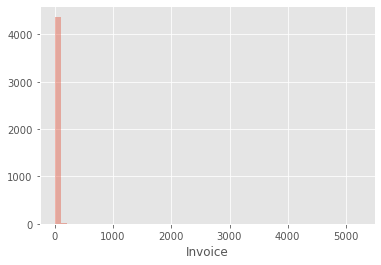

In [60]:
sns.distplot(n_orders, kde=False, hist=True)
ax.set(title='Distribution of number of orders per customer',
       xlabel='# of orders', 
       ylabel='# of customers');

In [61]:
df = df[['Customer ID', 'Invoice', 'InvoiceDate']].drop_duplicates()

In [62]:
df['order_month'] = df['InvoiceDate'].dt.to_period('M')

In [63]:
df.head(2)

,Customer ID,Invoice,InvoiceDate,order_month
0,13085.0,489434,2009-12-01 07:45:00,2009-12
8,13085.0,489435,2009-12-01 07:46:00,2009-12


In [64]:
df['cohort'] = df.groupby('Customer ID')['InvoiceDate'].transform('min').dt.to_period('M')
df.head(2)

,Customer ID,Invoice,InvoiceDate,order_month,cohort
0,13085.0,489434,2009-12-01 07:45:00,2009-12,2009-12
8,13085.0,489435,2009-12-01 07:46:00,2009-12,2009-12


In [65]:
df.tail(2)

,Customer ID,Invoice,InvoiceDate,order_month,cohort
525371,13969.0,538170,2010-12-09 19:32:00,2010-12,2010-03
525396,17530.0,538171,2010-12-09 20:01:00,2010-12,2009-12


In [66]:
df_cohort = df.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('Customer ID', 'nunique')) \
              .reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))
df_cohort.head(2)

,cohort,order_month,n_customers,period_number
0,2009-12,2009-12,1046,0
1,2009-12,2010-01,393,1


In [67]:
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')
cohort_pivot.head(2)

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2009-12,1046.0,393.0,359.0,448.0,411.0,409.0,409.0,375.0,356.0,393.0,453.0,519.0,261.0
2010-01,394.0,86.0,119.0,120.0,110.0,115.0,105.0,91.0,114.0,134.0,122.0,37.0,NaN


In [68]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
retention_matrix.head(2)

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2009-12,1.0,0.375717,0.343212,0.428298,0.392925,0.391013,0.391013,0.358509,0.340344,0.375717,0.433078,0.496176,0.249522
2010-01,1.0,0.218274,0.302030,0.304569,0.279188,0.291878,0.266497,0.230964,0.289340,0.340102,0.309645,0.093909,NaN


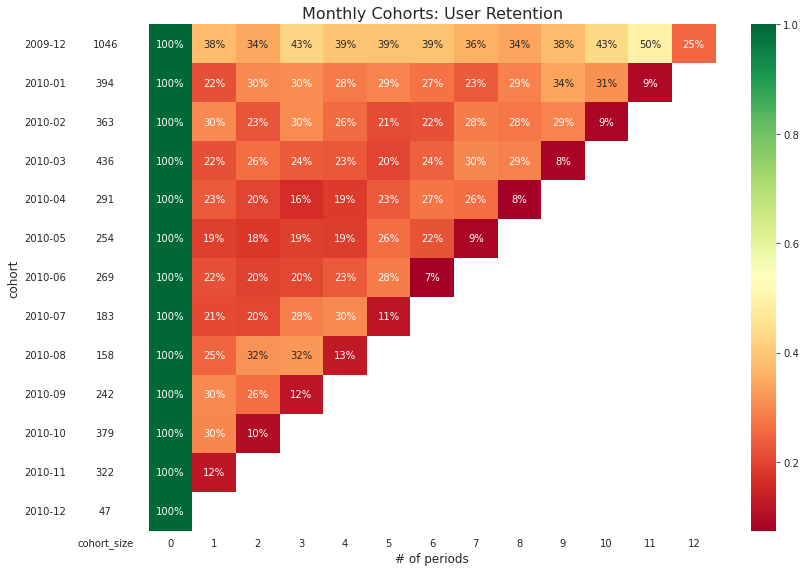

In [69]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()